# CUSTOMER CHURN ANALYSIS

## Import Library

In [40]:
# Library for data analysis
import numpy as np
import pandas as pd

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library for machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Setting parameter kernel
plt.rcParams['figure.figsize'] = [10,6]
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Import Raw Data

In [41]:
# Read file as dataframe
df = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/data_retail.csv', sep = ';')
# Print first five rows
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Sepatu,1406077331494,1545735761270,1269337,41
2,3,3,141526,Tas,1493349147000,1548322802000,310915,30
3,4,4,141526,Jaket,1493362372547,1547643603911,722632,27
4,5,5,37545,Sepatu,1429178498531,1542891221530,1775036,25


In [42]:
print('Info dataset:')
df.info()

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   no                          100000 non-null  int64 
 1   Row_Num                     100000 non-null  int64 
 2   Customer_ID                 100000 non-null  int64 
 3   Product                     100000 non-null  object
 4   First_Transaction           100000 non-null  int64 
 5   Last_Transaction            100000 non-null  int64 
 6   Average_Transaction_Amount  100000 non-null  int64 
 7   Count_Transaction           100000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB


### Data Wrangling

In [43]:
# Change format column First_Transaction and Last Transaction
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='1970-01-01')
df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='1970-01-01')
# View new format
df[['First_Transaction','Last_Transaction']].head()

,First_Transaction,Last_Transaction
0,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040
1,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981
2,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000
3,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013
4,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970


In [44]:
# Check Last Transaction update
print(max(df['Last_Transaction']))

2019-02-01 23:57:57.286000013


In [45]:
# Create new column is_Churn
df.loc[df['Last_Transaction'] <= '2018-08-01', 'is_Churn'] = True 
df.loc[df['Last_Transaction'] > '2018-08-01', 'is_Churn'] = False 

In [46]:
# Remove unnecessary columns
del df['no']
del df['Row_Num']

### Clean Dataset

In [47]:
# View first five rows after cleaning data
df.head()

,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction,is_Churn
0,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22,False
1,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41,False
2,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30,False
3,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27,False
4,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25,False


In [48]:
# View info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Customer_ID                 100000 non-null  int64         
 1   Product                     100000 non-null  object        
 2   First_Transaction           100000 non-null  datetime64[ns]
 3   Last_Transaction            100000 non-null  datetime64[ns]
 4   Average_Transaction_Amount  100000 non-null  int64         
 5   Count_Transaction           100000 non-null  int64         
 6   is_Churn                    100000 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 5.3+ MB


## Data Visualization

### Customer Acquisition By Year

In [49]:
# Create new column Year First Transaction
df['Year_First_Transaction'] = df['First_Transaction'].dt.year
# Create new column Last Transaction
df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year
# Grouping Number of Customers by Year
cust_by_year = df.groupby(['Year_First_Transaction'])['Customer_ID'].count()
cust_by_year

Year_First_Transaction
2013     1007
2014     4954
2015    11235
2016    17656
2017    31828
2018    30327
2019     2993
Name: Customer_ID, dtype: int64

Text(0, 0.5, 'Number of Customers')

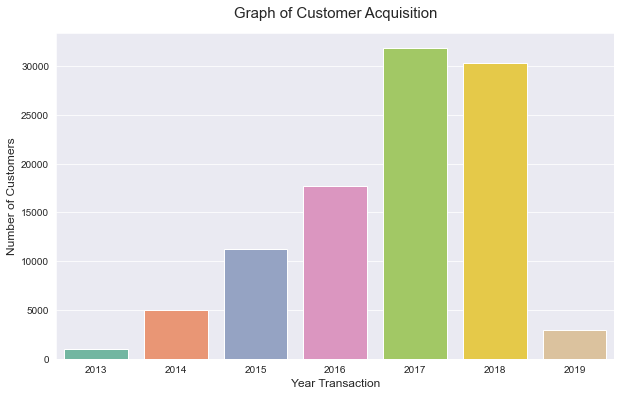

In [50]:
# Plotting number of customers by year
sns.barplot(x = cust_by_year.index, y = cust_by_year, palette='Set2')
plt.title('Graph of Customer Acquisition', fontsize=15, pad=15)
plt.xlabel('Year Transaction', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

### Transaction by Year

In [51]:
# Grouping total Count Transaction by Year
trans_by_year = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
trans_by_year

Year_First_Transaction
2013     23154
2014    165494
2015    297445
2016    278707
2017    299199
2018     99989
2019      5862
Name: Count_Transaction, dtype: int64

Text(0, 0.5, 'Total Transactions')

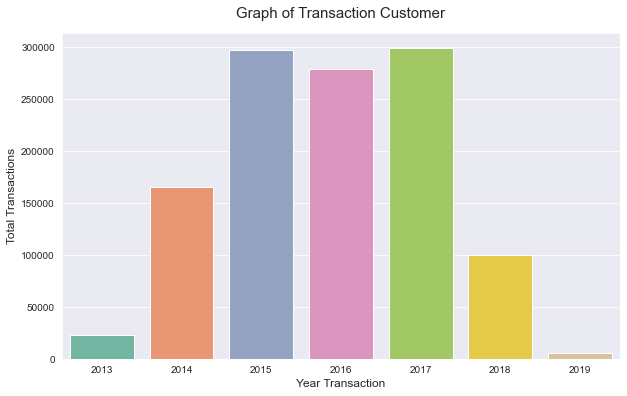

In [52]:
# Plotting total transactions by year
sns.barplot(x = trans_by_year.index, y = trans_by_year, palette='Set2')
plt.title('Graph of Transaction Customer', fontsize=15, pad=15)
plt.xlabel('Year Transaction', fontsize=12)
plt.ylabel('Total Transactions', fontsize=12)

### Average Transaction Amount by Year

In [53]:
# Grouping Average Transaction Amount by Product and Year
avg_trans_amount = df.groupby(['Product', 'Year_First_Transaction'])['Average_Transaction_Amount'].mean().reset_index()
avg_trans_amount

,Product,Year_First_Transaction,Average_Transaction_Amount
0,Baju,2017,1.490890e+06
1,Baju,2018,1.570201e+06
2,Baju,2019,1.383645e+06
3,Jaket,2014,1.467937e+06
4,Jaket,2015,1.296265e+06
5,Jaket,2016,1.317344e+06
6,Jaket,2017,1.369034e+06
7,Jaket,2018,1.419074e+06
8,Jaket,2019,1.447536e+06
9,Sepatu,2013,1.396499e+06


Text(0, 0.5, 'Average Transaction Amount')

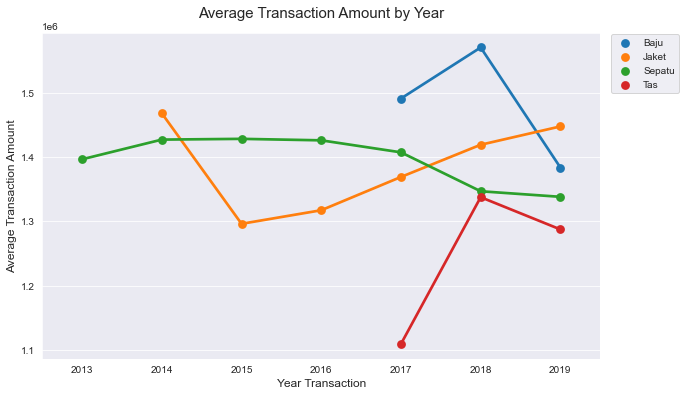

In [54]:
# Plotting by Product
sns.pointplot(data = avg_trans_amount, x='Year_First_Transaction', 
              y='Average_Transaction_Amount', hue='Product')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.01))
plt.title('Average Transaction Amount by Year', fontsize=15, pad=15)
plt.xlabel('Year Transaction', fontsize=12)
plt.ylabel('Average Transaction Amount', fontsize=12)

### Churn Customer Proportion

In [55]:
# Create pivot table
churn_prop = df.pivot_table(index='is_Churn', 
                        columns='Product',
                        values='Customer_ID', 
                        aggfunc='count', 
                        fill_value=0)
churn_prop

Product,Baju,Jaket,Sepatu,Tas
is_Churn,,,,
False,1268,11123,16064,4976
True,2144,23827,33090,7508


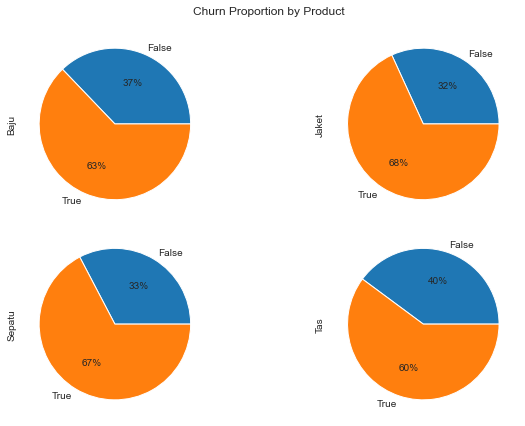

In [56]:
# Plotting churn proportion using pie plot
churn_prop.plot.pie(subplots=True, layout=(2,2), autopct='%1.0f%%', 
                    legend=False, title='Churn Proportion by Product')
plt.tight_layout()

### Distribution Count Transaction

In [57]:
# Create function distribution count transaction
def distribution_count_trans(row):
    if row['Count_Transaction'] == 1:
        val = '1'
    elif (row['Count_Transaction'] > 1 and row['Count_Transaction'] <= 3):
        val ='2 - 3'
    elif (row['Count_Transaction'] > 3 and row['Count_Transaction'] <= 6):
        val ='4 - 6'
    elif (row['Count_Transaction'] > 6 and row['Count_Transaction'] <= 10):
        val ='7 - 10'
    else:
        val ='> 10'
    return val

In [58]:
# Apply function to new column
df['Count_Transaction_Group'] = df.apply(distribution_count_trans, axis=1)
# Grouping Number of Customers by Count Transaaction Group
count_trans_group = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()
count_trans_group

Count_Transaction_Group
1         49255
2 - 3     14272
4 - 6     12126
7 - 10     2890
> 10      21457
Name: Customer_ID, dtype: int64

Text(0, 0.5, 'Number of Customers')

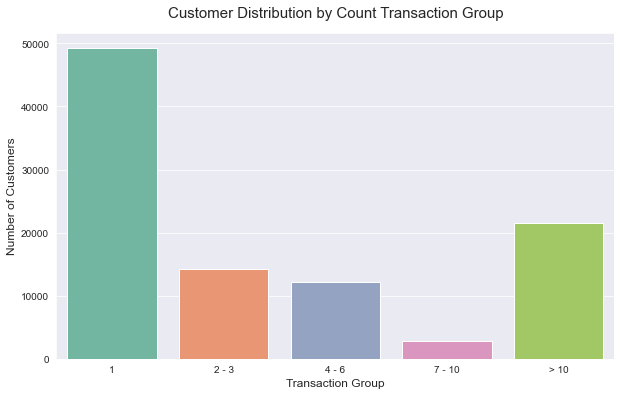

In [59]:
# Plotting count transaction group 
sns.barplot(x = count_trans_group.index, y = count_trans_group, palette='Set2')
plt.title('Customer Distribution by Count Transaction Group', fontsize=15, pad=15)
plt.xlabel('Transaction Group', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

### Distribution Average Transaction

In [60]:
# Create function distribution average transaction
def distribution_avg_trans(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <= 200000):
        val ='100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <= 500000):
        val ='>250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 750000):
        val ='>500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <= 1000000):
        val ='>750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val ='>1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val ='>2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val ='>5.000.000 - 10.000.000'
    else:
        val ='>10.000.000'
    return val

In [61]:
# Apply function to new column
df['Average_Transaction_Amount_Group'] = df.apply(distribution_avg_trans, axis=1)
# Grouping Number of Customers by Average Transaction Amount Group
avg_trans_group = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()
avg_trans_group

Average_Transaction_Amount_Group
100.000 - 250.000           4912
>1.000.000 - 2.500.000     32819
>10.000.000                 3227
>2.500.000 - 5.000.000      9027
>250.000 - 500.000         18857
>5.000.000 - 10.000.000     3689
>500.000 - 750.000         15171
>750.000 - 1.000.000       12298
Name: Customer_ID, dtype: int64

Text(0, 0.5, 'Average Transaction Amount Group')

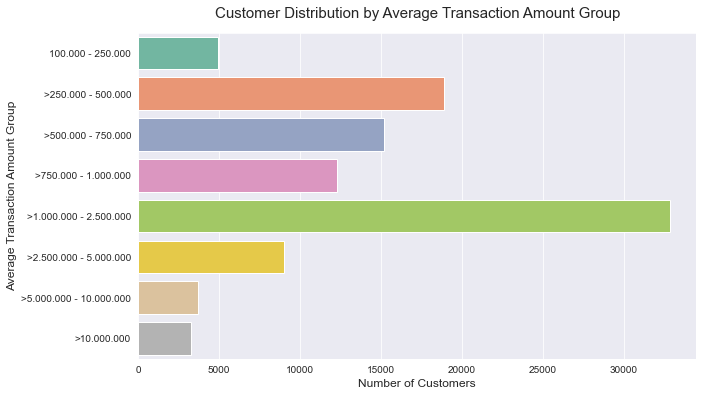

In [62]:
# Plotting average transaction amount group
orders = ['100.000 - 250.000', '>250.000 - 500.000', '>500.000 - 750.000',
          '>750.000 - 1.000.000', '>1.000.000 - 2.500.000', '>2.500.000 - 5.000.000',
          '>5.000.000 - 10.000.000', '>10.000.000']
sns.barplot(x = avg_trans_group, y = avg_trans_group.index, order=orders, palette='Set2')
plt.title('Customer Distribution by Average Transaction Amount Group', fontsize=15, pad=15)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Average Transaction Amount Group', fontsize=12)

## Data Modelling

### Feature Engineering

In [63]:
# Check datatypes
df.dtypes

Customer_ID                                  int64
Product                                     object
First_Transaction                   datetime64[ns]
Last_Transaction                    datetime64[ns]
Average_Transaction_Amount                   int64
Count_Transaction                            int64
is_Churn                                    object
Year_First_Transaction                       int64
Year_Last_Transaction                        int64
Count_Transaction_Group                     object
Average_Transaction_Amount_Group            object
dtype: object

In [64]:
# Copy old dataframe
df_model = df.copy()
# Create new column from First Transaction
df_model['Month_First'] = df_model['First_Transaction'].dt.month
df_model['Day_First'] = df_model['First_Transaction'].dt.day
# Create new column from Last Transaction
df_model['Month_Last'] = df_model['Last_Transaction'].dt.month
df_model['Day_Last'] = df_model['Last_Transaction'].dt.day

In [65]:
# Encoding categorical data
df_model['Count_Transaction_Group'].replace({'1':0, '2 - 3':1, '4 - 6':2, '7 - 10':3,
                                             '> 10':4}, inplace=True)
amounts = {'100.000 - 250.000':0, '>250.000 - 500.000':1, '>500.000 - 750.000':2,
          '>750.000 - 1.000.000':3, '>1.000.000 - 2.500.000':4, '>2.500.000 - 5.000.000':5,
          '>5.000.000 - 10.000.000':6, '>10.000.000':7}
df_model['Average_Transaction_Amount_Group'].replace(amounts, inplace=True)
df_model['is_Churn'].replace({False:0, True:1}, inplace=True)

In [66]:
# Perform one hot encoding
df_encode = pd.get_dummies(df_model['Product'])
# Selected columns
remove_cols = ['Product', 'First_Transaction', 'Last_Transaction', 'Count_Transaction', 'Average_Transaction_Amount']
df_fix = df_model.drop(remove_cols, axis=1)
# Concatenate dataframe
df_model_fix = pd.concat([df_fix, df_encode], axis=1)

# Check new first five rows
df_model_fix.head()

,Customer_ID,is_Churn,Year_First_Transaction,Year_Last_Transaction,Count_Transaction_Group,Average_Transaction_Amount_Group,Month_First,Day_First,Month_Last,Day_Last,Baju,Jaket,Sepatu,Tas
0,29531,0,2016,2018,4,4,6,19,10,5,0,1,0,0
1,29531,0,2014,2018,4,4,7,23,12,25,0,0,1,0
2,141526,0,2017,2019,4,1,4,28,1,24,0,0,0,1
3,141526,0,2017,2019,4,2,4,28,1,16,0,1,0,0
4,37545,0,2015,2018,4,4,4,16,11,22,0,0,1,0


In [67]:
# Check new data type
df_model_fix.dtypes

Customer_ID                         int64
is_Churn                            int64
Year_First_Transaction              int64
Year_Last_Transaction               int64
Count_Transaction_Group             int64
Average_Transaction_Amount_Group    int64
Month_First                         int64
Day_First                           int64
Month_Last                          int64
Day_Last                            int64
Baju                                uint8
Jaket                               uint8
Sepatu                              uint8
Tas                                 uint8
dtype: object

In [68]:
# View Total Proportion Churn
df_model_fix['is_Churn'].value_counts(normalize=True)

1    0.66569
0    0.33431
Name: is_Churn, dtype: float64

### Split Train and Test Data

In [69]:
# Choose feature columns
X = df_model_fix.drop(['Customer_ID','is_Churn'], axis=1)
# Choose target columns
y = df_model_fix['is_Churn']

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Model Selection

In [70]:
# Create function choose model
def choose_model(model_name):
  # Train model
  model = model_name.fit(X_train, y_train)
  # Scoring Model
  model_score = model.score(X_test, y_test)
  print(f'Score Accuracy is {round(model_score*100, 2)}%')
  # Validating Model
  valid_score = np.mean(cross_val_score(model_name, X_train, y_train, cv=5))
  print(f'Score Validation is {round(valid_score*100, 2)}%')

In [71]:
# Choose model
choose_model(LogisticRegression())

Score Accuracy is 76.2%
Score Validation is 76.27%


In [72]:
# Choose model
choose_model(xgb.XGBClassifier())

[08:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score Accuracy is 100.0%
[08:50:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:50:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:50:29] WARNING: C:/Users/Administrator/wo

### Model Evaluation

In [73]:
# Function for plot confusion matrix and classification report
def check_matrix_and_reports(model_plot):
    # Churn Prediction 
    train = model_plot.fit(X_train, y_train)
    preds = train.predict(X_test)

    # Create confusion matrix
    class_names = ['Not Churn', 'Churn'] 
    cnf_matrix = confusion_matrix(y_test, preds)
    # Use subplotting
    fig, ax = plt.subplots(figsize=(8,4))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # Plotting using heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
    plt.title('Confusion matrix', fontsize=15, pad=15)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Create classification report
    reports = classification_report(y_test, preds, target_names=class_names)
    print('Classification Report\n', reports)

Classification Report
               precision    recall  f1-score   support

   Not Churn       0.72      0.48      0.57      8399
       Churn       0.77      0.91      0.83     16601

    accuracy                           0.76     25000
   macro avg       0.75      0.69      0.70     25000
weighted avg       0.76      0.76      0.75     25000



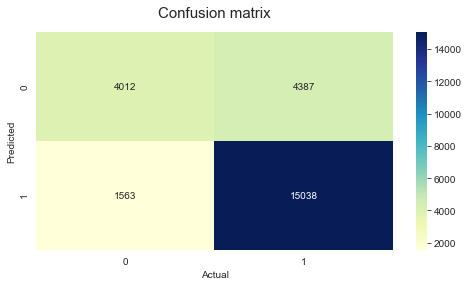

In [74]:
# Apply function with Logistic Regression
check_matrix_and_reports(LogisticRegression())

In [ ]:
# Apply function with XGBoost Classifier
check_matrix_and_reports(xgb.XGBClassifier())

[08:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# Predict probability of churn
model1 = LogisticRegression().fit(X_train, y_train)
log_pred = model1.predict_proba(X_test)[:,1]
model2 = xgb.XGBClassifier().fit(X_train, y_train)
xgb_pred = model2.predict_proba(X_test)[:,1]

# ROC Chart components
fallout_log, sensitivity_log, thresholds_log = roc_curve(y_test, log_pred)
fallout_xgb, sensitivity_xgb, thresholds_xgb = roc_curve(y_test, xgb_pred)

# ROC Chart with both
plt.plot(fallout_log, sensitivity_log, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_xgb, sensitivity_xgb, color = 'green', label='%s' % 'XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart on Probability of Churn")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()

In [ ]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, log_pred))

# Print the xgboost classifier AUC with formatting
print("XGBoost Classifier AUC Score: %0.2f" % roc_auc_score(y_test, xgb_pred))